<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be sometime that can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [29]:
from skimage import data, io, filters
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity
import os

import numpy as np
import scipy.ndimage as nd


## Instatiate Model

#### Testing

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


<function skimage.io._io.show()>

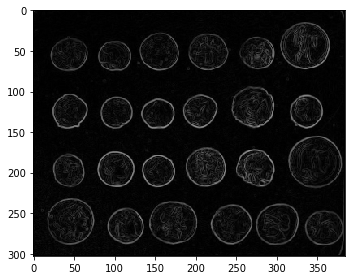

In [2]:
img = data.coins()
edges = filters.sobel(img)
edges
io.imshow(edges)
io.show

In [3]:

#Be aware of file types that store the data diffrently
# images are represented in 3 dimmensions
path_forest = "./data/forest/art114.jpg"
forest = io.imread(path_forest) 
forest_gray = rescale_intensity(color.rgb2gray(forest))
forest_gray

path_mount = "./data/mountain/art1131.jpg"
mount = io.imread(path_mount)
mount_gray = rescale_intensity(color.rgb2gray(mount))
mount_gray

array([[1.48976471e-02, 7.99650980e-02, 2.17570196e-01, ...,
        2.52999216e-01, 2.54665882e-01, 2.59688627e-01],
       [1.79858824e-02, 5.25141176e-02, 2.04138824e-01, ...,
        2.28949020e-01, 2.28666275e-01, 2.23873725e-01],
       [1.85513725e-02, 5.08474510e-02, 2.33026275e-01, ...,
        2.28160392e-01, 2.28428235e-01, 2.28145490e-01],
       ...,
       [8.33333333e-04, 1.45098039e-01, 9.96078431e-01, ...,
        6.87389804e-01, 7.03076078e-01, 7.00553333e-01],
       [8.33333333e-04, 1.45098039e-01, 9.96078431e-01, ...,
        6.87389804e-01, 6.87389804e-01, 6.89927451e-01],
       [8.33333333e-04, 1.39204314e-01, 9.96078431e-01, ...,
        6.86824314e-01, 6.73958431e-01, 6.86005882e-01]])

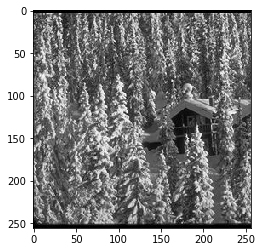

In [4]:
plt.imshow(mount_gray, cmap="gray")
plt.imshow(forest_gray, cmap="gray");

In [5]:
print(forest_gray.shape)
print(mount_gray.shape)

(256, 256)
(256, 256)


In [6]:

horizontal_edge_convo = np.array([[1,1,1,1,1],
                                 [0,0,0,0,0],
                                 [0,0,0,0,0],
                                 [0,0,0,0,0],
                                 [-1, -1, -1, -1, -1]])

vertical_edge_convo = np.array([[1,0,0,0,-1],
                               [1,0,0,0,-1],
                               [1,0,0,0,-1],
                               [1,0,0,0,-1],
                               [1,0,0,0,-1],])

forest_edge = nd.convolve(forest_gray, vertical_edge_convo)
forest_edge.shape

(256, 256)

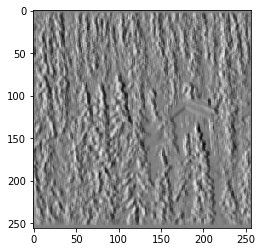

In [7]:
plt.imshow(forest_edge, cmap="gray");

(256, 256)


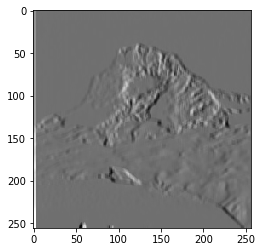

In [8]:
mount_edge = nd.convolve(mount_gray, vertical_edge_convo)
print(mount_edge.shape)
plt.imshow(mount_edge, cmap='gray');

#### Get images from file

In [9]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage.io import imread_collection

def process_img_path(img_path):
    return image.load_img(img_path, target_size=(224, 224))

def img_contains_mtn(img):
    
    # Need to do to deal with ResNet functionality
    x = image.img_to_array(img) # Converts PIL image instance into a numpy array
    x = np.expand_dims(x, axis=0) # Expand the shape of the array
    x = preprocess_input(x) 
    
    #Instantiate the model
    model = ResNet50(weights='imagenet')
    
    # Predictions
    features = model.predict(x)
    
    # Decode
    results = decode_predictions(features, top=3)[0]
    print(results)
    
    # Detector
    for entry in results:
        if entry[1] == 'mountain':
            return entry[2]
    return 0.0

def img_contains_fst(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    print(results)
    for entry in results:
        if entry[1] == 'forest':
            return entry[2]
    return 0.0

In [10]:
import glob

# get list of file locations
mount_jpg = glob.glob("./data/mountain/*.jpg")
forest_jpg = glob.glob("./data/forest/*.jpg")

mount_ls = []

for _ in mount_jpg:
    item = process_img_path(_)
    mount_ls.append(_)

print(f"Mountain list size: {len(mount_ls)}")

forest_ls = []

for _ in forest_jpg:
    item = process_img_path(_)
    forest_ls.append(_)
    
print(f"Forest list size: {len(forest_ls)}")

Mountain list size: 374
Forest list size: 328


#### Big Things to Know
- You need 2 functions that are going to help you understand how the pre train model is going to work.

1. You need a function to map your input image, to match the input image the model expects
2. You need to know how to decode the predictions

#### Single mountain prediction

In [61]:
mountain_test = process_img_path("./data/mountain/art1131.jpg")
mount_test = img_contains_mtn(mountain_test)

[('n09193705', 'alp', 0.9746936), ('n09468604', 'valley', 0.005970514), ('n04228054', 'ski', 0.0027997063)]


#### Single forest prediction

In [62]:
forest_test = process_img_path("./data/forest/art114.jpg")
fst_test = img_contains_fst(forest_test)

[('n02843684', 'birdhouse', 0.20658226), ('n03388043', 'fountain', 0.17771536), ('n02999410', 'chain', 0.07041899)]


#### Creating labels 

In [19]:
ones = np.ones(len(mount_ls)).astype(int)
print(len(ones))
zeros = np.zeros(len(forest_ls)).astype(int)
print(len(zeros))

374
328


#### Turn images into an array

In [20]:
# Loads collection of images
mount_array = imread_collection(mount_ls)
forest_array = imread_collection(forest_ls)

In [21]:
X = np.concatenate((mount_array,forest_array))
y = np.concatenate((ones,zeros))

In [23]:
# Starter code given to us
resnet = ResNet50(weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False
    x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


## Fit Model

In [27]:
model.fit(X,y, epochs=1)

Instructions for updating:
Use tf.cast instead.
702/702 [==============================] - 184s 262ms/sample - loss: 0.0863 - acc: 0.8875


In [28]:
model.evaluate(X,y)

702/702 [==============================] - 134s 191ms/sample - loss: 0.0207 - acc: 0.9729


[0.020745533967885418, 0.9729345]

# Custom CNN Model

In [121]:
# Compile Model


In [122]:
# Fit Model


# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [1]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language